In [2]:
import pandas as pd
import numpy as np
from os.path import exists
from os import mkdir

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import open3d as o3d

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

PLOTDIR = "plots"
DATADIR = "data"

DIRS = [PLOTDIR, DATADIR]

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

def data_path(filename):
    return DATADIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)     
        
output_dir = f"figures/experiments/"

#data files are shown as eg. AICS-31 1857 Dots (1)

In [3]:
# Organoid_Names are the file names of the positional data from the organoid staining

Organoid_Names = ['HW8D60SUPB15_VOL_1.xls',
                  'HW8D60SUPB15_VOL_2.xls',
                  'HW8D60SUPB15_VOL_3.xls', 
                  'HW8D60697_VOL_1.xls',
                  'HW8D60697_VOL_2.xls',
                  'HW8D60697_VOL_3.xls',
                  'HW8D60KASUMI2_VOL_1.xls',
                  'HW8D60KASUMI2_VOL_2.xls', 
                  'HW8D60KASUMI2_VOL_3.xls']

organoid_pts = []

for name in Organoid_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    organoid_pts.append(pts)

In [4]:
Entity_Names = ['HW8D60SUPB15_DOTS_1.xls',
                'HW8D60SUPB15_DOTS_2.xls',
                'HW8D60SUPB15_DOTS_3.xls', 
                'HW8D60697_DOTS_1.xls',
                'HW8D60697_DOTS_2.xls',
                'HW8D60697_DOTS_3.xls',
                'HW8D60KASUMI2_DOTS_1.xls',
                'HW8D60KASUMI2_DOTS_2.xls', 
                'HW8D60KASUMI2_DOTS_3.xls']

entity_pts = []

for name in Entity_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    entity_pts.append(pts)

In [5]:
assert len(organoid_pts)==len(entity_pts)

distances = []

for index in range(len(organoid_pts)):
    # Organoids
    pcd_org = o3d.geometry.PointCloud()
    pcd_org.points = o3d.utility.Vector3dVector(organoid_pts[index])
    pcd_org.compute_convex_hull()
    pcd_org.estimate_normals()
    pcd_org.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_org, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_org, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_org.paint_uniform_color([0.8, 0, 0])
    mesh_org.compute_vertex_normals()
    mesh_org.filter_smooth_simple(number_of_iterations=1)
    
    mesh_to_fill_org = o3d.t.geometry.TriangleMesh.from_legacy(mesh_org)
    mesh_to_fill_org.fill_holes(hole_size=10)
    final_mesh_org = mesh_to_fill_org.to_legacy()
    
    # Entities
    pcd_ent = o3d.geometry.PointCloud()
    pcd_ent.points = o3d.utility.Vector3dVector(entity_pts[index])
    pcd_ent.compute_convex_hull()
    pcd_ent.estimate_normals()
    pcd_ent.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_ent, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_ent, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_ent.paint_uniform_color([0.8, 0, 0])
    mesh_ent.compute_vertex_normals()
    mesh_ent.filter_smooth_simple(number_of_iterations=1)
    
    mesh_to_fill_ent = o3d.t.geometry.TriangleMesh.from_legacy(mesh_ent)
    mesh_to_fill_ent.fill_holes(hole_size=10)
    final_mesh_ent = mesh_to_fill_ent.to_legacy()
    
    # Calculation of distances
    mesh_org_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_org)
    mesh_ent_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_ent)
    
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(mesh_org_toleg)] = 'surface'
    mesh_ids[scene.add_triangles(mesh_ent_toleg)] = 'cells'

    query_point = np.asarray(entity_pts[index]).astype('float32')

    unsigned_distance = scene.compute_distance(query_point)
    distances.append(unsigned_distance.numpy())
    
    

[Open3D DEBUG] Input Points / Samples: 13962 / 10444
[Open3D DEBUG] #   Got kernel density: 0.00585294 (s), 261.91 (MB) / 261.91 (MB) / 271 (MB)
[Open3D DEBUG] #     Got normal field: 0.0357931 (s), 267.008 (MB) / 267.008 (MB) / 271 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 2.427888e-06 / 3.389818e-02
[Open3D DEBUG] #       Finalized tree: 0.0290260 (s), 276.168 (MB) / 276.168 (MB) / 276 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0577729 (s), 276.266 (MB) / 276.266 (MB) / 276 (MB)
[Open3D DEBUG] #Set point constraints: 0.00702906 (s), 277.086 (MB) / 277.086 (MB) / 277 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 197023 / 216952 / 8217
[Open3D DEBUG] Memory Usage: 277.086 MB
[Open3D DEBUG] # Linear system solved: 0.182111 (s), 283.855 (MB) / 283.855 (MB) / 283 (MB)
[Open3D DEBUG] Got average: 0.00373697 (s), 279.102 (MB) / 283.855 (MB) / 283 (MB)
[Open3D DEBUG] Iso-Value: 5.170908e-01 = 7.219621e+03 / 1.396200e+04
[Open3D DEBUG] #          Total Solve:       

[Open3D DEBUG] # Linear system solved: 0.142531 (s), 407.621 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] Got average: 0.00394011 (s), 405.152 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] Iso-Value: 5.191491e-01 = 1.044009e+03 / 2.011000e+03
[Open3D DEBUG] #          Total Solve:       0.8 (s),     429.8 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 8362 / 7156
[Open3D DEBUG] #   Got kernel density: 0.00492692 (s), 408.828 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] #     Got normal field: 0.0265121 (s), 410.375 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 3.211988e-06 / 2.685865e-02
[Open3D DEBUG] #       Finalized tree: 0.0259831 (s), 416.32 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0704100 (s), 417.676 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] #Set point constraints: 0.00498915 (s), 417.676 (MB) / 429.773 (MB) / 455 (MB)
[Open3D D

[Open3D DEBUG] #          Total Solve:       0.8 (s),     429.8 (MB)epth[10/10]:	Updated constraints / Got system / Solved in:  0.004 /  0.008 /  0.011	(339.773 MB)	Nodes: 15568
                    GS: 2.5286e-02 -> 2.5286e-02 -> 1.7763e-05 (7.0e-04) [8]
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(377.207 MB)	Nodes: 8
CG: 1.2656e-02 -> 1.2656e-02 -> 9.0648e-06 (7.2e-04) [32721]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(377.207 MB)	Nodes: 27
  GS: 4.8188e-02 -> 4.8188e-02 -> 8.1679e-04 (1.7e-02) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(377.207 MB)	Nodes: 125
    GS: 7.2591e-02 -> 7.2591e-02 -> 1.9357e-03 (2.7e-02) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.001	(377.426 MB)	Nodes: 729
      GS: 1.2097e-01 -> 1.2097e-01 -> 2.9167e-03 (2.4e-02) [8]
Cycle[0] Depth[ 4/10]:	Updated c

[Open3D DEBUG] # Linear system solved: 0.148565 (s), 398.68 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] Got average: 0.00303698 (s), 396.535 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] Iso-Value: 5.180019e-01 = 1.017874e+03 / 1.965000e+03
[Open3D DEBUG] #          Total Solve:       0.9 (s),     429.8 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 30921 / 21979
[Open3D DEBUG] #   Got kernel density: 0.00707507 (s), 415.258 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] #     Got normal field: 0.0396678 (s), 417.707 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 8.532014e-07 / 2.638184e-02
[Open3D DEBUG] #       Finalized tree: 0.027528 (s), 420.797 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0749919 (s), 422.188 (MB) / 429.773 (MB) / 455 (MB)
[Open3D DEBUG] #Set point constraints: 0.00970197 (s), 422.188 (MB) / 429.773 (MB) / 455 (MB)
[Open3D 

[Open3D DEBUG] #          Total Solve:       0.9 (s),     430.6 (MB)ted constraints / Got system / Solved in:  0.002 /  0.015 /  0.020	(409.480 MB)	Nodes: 35937
          GS: 1.9712e-01 -> 1.9712e-01 -> 2.4479e-03 (1.2e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.002 /  0.002	(409.480 MB)	Nodes: 2920
            GS: 1.9516e-01 -> 1.9516e-01 -> 7.0165e-04 (3.6e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.002 /  0.003	(409.480 MB)	Nodes: 4672
              GS: 1.7621e-01 -> 1.7621e-01 -> 1.0665e-03 (6.1e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.004 /  0.004 /  0.007	(409.480 MB)	Nodes: 12704
                GS: 1.5418e-01 -> 1.5418e-01 -> 1.1558e-03 (7.5e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.005 /  0.011 /  0.016	(409.480 MB)	Nodes: 38528
                  GS: 1.0929e-01 -> 1.0929e-01 -> 9.3145e-04 (8.5e-03) [8]
Cycle[

Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.006 /  0.009 /  0.015	(412.418 MB)	Nodes: 29168
                  GS: 8.5468e-02 -> 8.5468e-02 -> 5.9407e-04 (7.0e-03) [8]
Cycle[0] Depth[10/10]:	Updated constraints / Got system / Solved in:  0.004 /  0.019 /  0.024	(416.723 MB)	Nodes: 75120
                    GS: 5.0659e-02 -> 5.0659e-02 -> 2.2086e-04 (4.4e-03) [8]
Cycle[0] Depth[ 0/10]:	Updated constraints / Got system / Solved in:  0.000 /  0.000 /  0.000	(400.117 MB)	Nodes: 8
CG: 4.9962e-03 -> 4.9962e-03 -> 4.7548e-07 (9.5e-05) [32721]
Cycle[0] Depth[ 1/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.000 /  0.000	(400.117 MB)	Nodes: 27
  GS: 3.1734e-02 -> 3.1734e-02 -> 2.3649e-04 (7.5e-03) [8]
Cycle[0] Depth[ 2/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.001 /  0.000	(400.117 MB)	Nodes: 125
    GS: 4.9847e-02 -> 4.9847e-02 -> 6.1580e-04 (1.2e-02) [8]
Cycle[0] Depth[ 3/10]:	Updated constraints / Got system / Solved in:  0.001 

In [6]:
dict_keys = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

d = dict(zip(dict_keys, distances))

df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")

df.loc[df['Entity'] == 'A', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'B', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'C', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'D', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'E', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'F', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'G', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'H', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'I', 'Types'] = 'Repeat 3'

df["Entity"] = df["Entity"].replace({'A':'SUPB15',
              'B':'SUPB15',
              'C':'SUPB15',
              'D':'697',
              'E':'697',
              'F':'697',
              'G':'Kasumi2',
              'H':'Kasumi2',
              'I':'Kasumi2'}) 

df[np.isfinite(df["Distance to Surface (\u03BCm)"])]
df_final = df[df["Distance to Surface (\u03BCm)"] > 0.0001]

display(df_final)

Entity  Distance to Surface (μm)     Types
0       SUPB15                  1.885051  Repeat 1
1       SUPB15                  2.056081  Repeat 1
2       SUPB15                  0.900723  Repeat 1
3       SUPB15                  0.245485  Repeat 1
4       SUPB15                  0.137147  Repeat 1
...        ...                       ...       ...
33260  Kasumi2                  1.301344  Repeat 3
33261  Kasumi2                  4.156994  Repeat 3
33262  Kasumi2                 22.423944  Repeat 3
33263  Kasumi2                 22.918573  Repeat 3
33264  Kasumi2                 16.174341  Repeat 3

[20701 rows x 3 columns]

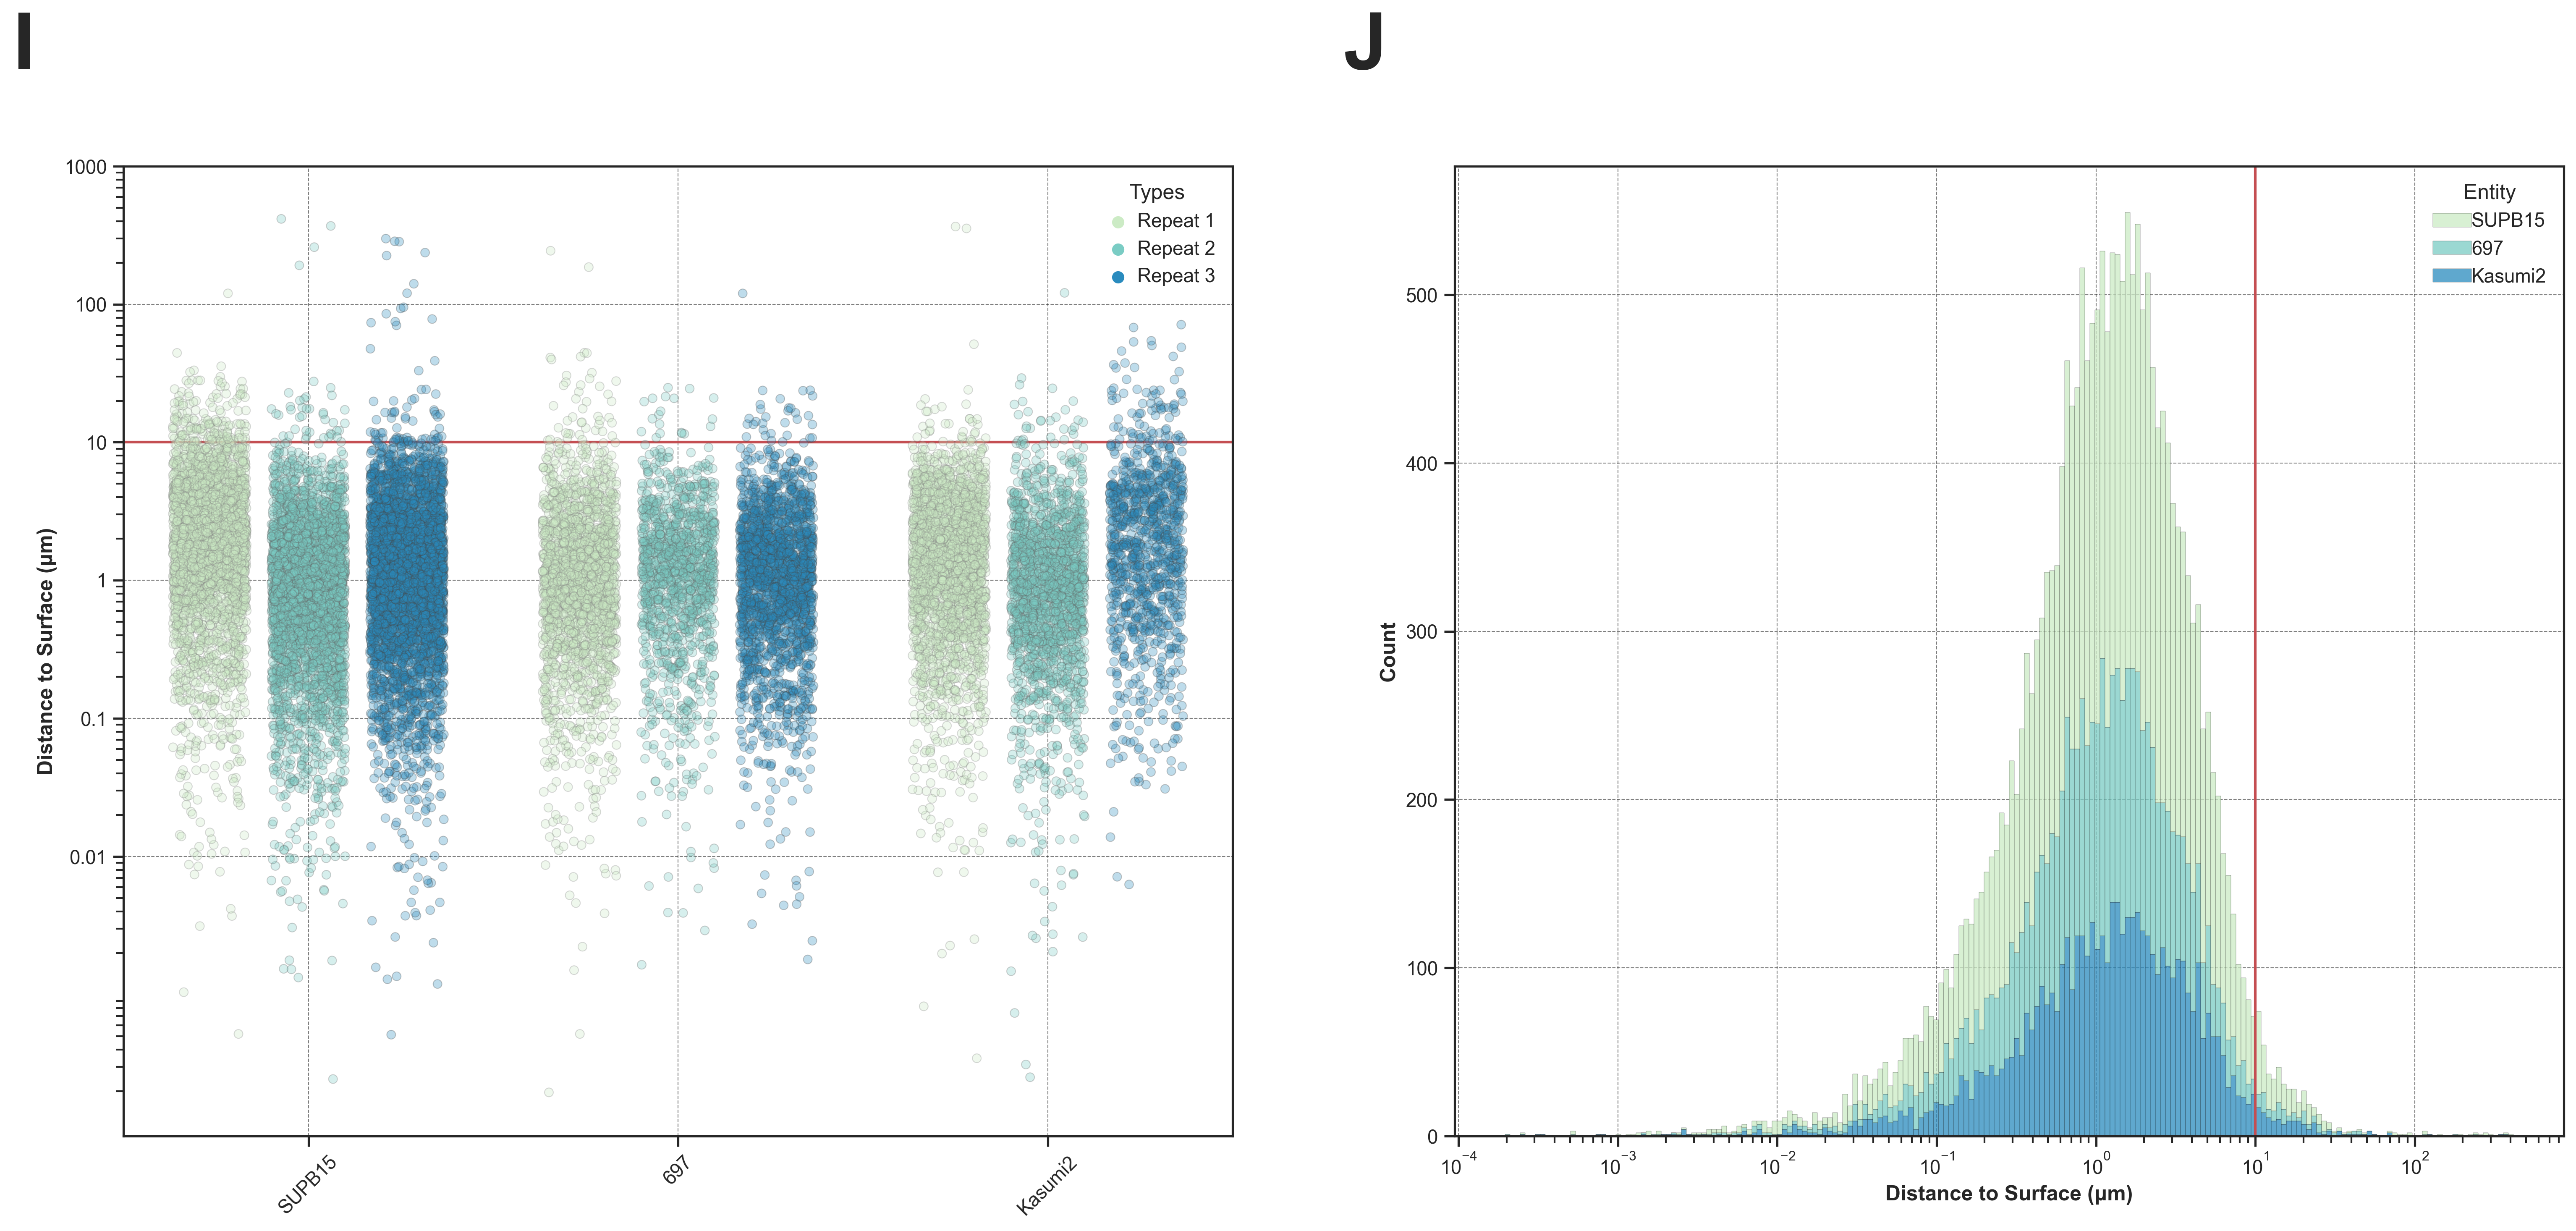

In [7]:
sns.set_theme(style="ticks")

fig, axes = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [1, 1]})
g = sns.stripplot(ax=axes[0], data=df_final,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="GnBu", linewidth=0.5,
              size=5, alpha=0.3, jitter=.30, dodge=True,
                 )
g.set_yscale("log")
axes[0].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_xlabel('Entity', fontweight ='bold')
axes[0].set_ylabel('Distance to Surface (\u03BCm)', fontweight ='bold')

# the non-logarithmic labels
yticks = [0.01, 0.1, 1, 10, 100, 1000]
g.set_yticks(yticks)
g.set_yticklabels(yticks)

g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

g.axhline(10, color='r')

g = sns.histplot(
    df_final,
    x="Distance to Surface (\u03BCm)", hue="Entity",
    bins=200,
    multiple="stack",
    palette="GnBu",
    element="bars",
    edgecolor=".1",
    common_norm=False,
    kde=False,
    pmax=1000,
    linewidth=.1,
    stat="count",
    log_scale=True,
)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0)


axes[1].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_xlabel('Distance to Surface (\u03BCm)', fontweight ='bold')
axes[1].set_ylabel('Count', fontweight ='bold')

g.axvline(x=10, color='r')

texts = ['I', 'J']
ax = fig.get_axes()
for a,l in zip(ax, texts):
    a.annotate(l, xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=45, weight = 'bold')

#plt.savefig(plot_savepath('Seaborn_DepthAnalysis_other_entities.pdf'), bbox_inches='tight')
#plt.savefig(plot_savepath('Seaborn_DepthAnalysis_other_entities.png'), dpi=300, bbox_inches='tight')
plt.show()